# Model - Convolutional Neural Network

In the case of the CNN classifier, we applied word-embedding procedures
from the pre-processed texts using the word2vec API of Python Package, Gensim. The word vectors were pretrained
with the training dataset collected for the current study with continuous bag-of-words representation
(CBOW) models, while the size of window was set to five. Note that by using the pre-trained word2vec model
for representing each post for each subreddit, a language style used by users who write posts in a subreddit can
be trained for the specific subreddit.

##### Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# For handling imbalanced classes
from collections import Counter
from imblearn.over_sampling import SMOTE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

##### Load data

In [2]:
posts = pd.read_csv('../data/posts-preprocessed.csv')

In [3]:
posts.head(1)

,author,subreddit,timeframe,text,datetime,words,word_stems
0,sub21036,bulimia,pre-covid,['how can i stop hating myself i have been on...,2017-12-02 16:36:16,"['[', ""'how"", 'stop', 'hating', 'eating', 'dis...","['[', ""'how"", 'stop', 'hating', 'eating', 'dis..."


##### Binarize targets using get_dummies

Will use each subreddit as target (except mental health)

In [4]:
posts = pd.get_dummies(posts, columns=['subreddit'])

In [5]:
posts.drop(columns='subreddit_mentalhealth', inplace = True)

### Tokenizing the raw text

We will vectorize the text and prepare a training and validation split

In [6]:
texts = posts['text']

In [9]:
maxlen = 500 # Cuts off posts after 500 words
max_words = 10_000 # Considers only the top 10,00 words in the dataset

In [8]:
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [10]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 81346 unique tokens.


In [11]:
data = pad_sequences(sequences, maxlen=maxlen)

### Parcing the word2vec embeddings File

In [ ]:
labels = posts['subreddit_Anxiety']

In [ ]:
labels = np.asarray(labels)
print('Shape of data:', data.shape)
print('Shape of label:', labels.shape)

We will first use the previously created word2vec embeddings

#### Parsing the word-embeddings files

In [13]:
# The embeddings text file is in the current directory

embeddings_index = {}

f = open('embedding_word2vec.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vecotrs.' % len(embeddings_index))

Found 70591 word vecotrs.


#### Preparing the word-embeddings matrix

In [14]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector # Words not found in the embedding index will be all zeros

# Subreddit: Anxiety

#### Train test split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size = .2,
                                                    random_state=42)

In [16]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

#### Defining a model

In [18]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1600032   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 2,600,065
Trainable params: 2,600,065
Non-trainable params: 0
_________________________________________________________________


#### Loading the embeddings in the model

The Embedding layer has a single weight matrix: a 2D float matrix where each entry i is the word vector meant to be associated with the index i. 

We will load the Word2Vec matrix we prepared iinto the Embedding layer, the first layer in the model - 

In [19]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False # this freezes the embedding layer as to not 
                                  # be updated during training and forget what they already know

#### Training and evaluating the model

Compile and train the model.

##### Training and evaluation

In [20]:
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['acc'])

history = model.fit(X_train_sm, 
                    y_train_sm,
                   epochs = 10,
                   batch_size = 32,
                   validation_data = (X_test, y_test))

#model.save_weights('model1.h5')

Epoch 1/10
2601/2601 [==============================] - 12s 4ms/step - loss: 0.5580 - acc: 0.8032 - val_loss: 0.4694 - val_acc: 0.8540
Epoch 2/10
2601/2601 [==============================] - 11s 4ms/step - loss: 0.3246 - acc: 0.8686 - val_loss: 0.4725 - val_acc: 0.8692
Epoch 3/10
2601/2601 [==============================] - 11s 4ms/step - loss: 0.3109 - acc: 0.8749 - val_loss: 0.4981 - val_acc: 0.8762
Epoch 4/10
2601/2601 [==============================] - 11s 4ms/step - loss: 0.3058 - acc: 0.8765 - val_loss: 0.4732 - val_acc: 0.8857
Epoch 5/10
2601/2601 [==============================] - 11s 4ms/step - loss: 0.3257 - acc: 0.8779 - val_loss: 0.5763 - val_acc: 0.8848
Epoch 6/10
2601/2601 [==============================] - 11s 4ms/step - loss: 0.3062 - acc: 0.8786 - val_loss: 0.5440 - val_acc: 0.8860
Epoch 7/10
2601/2601 [==============================] - 11s 4ms/step - loss: 0.2994 - acc: 0.8780 - val_loss: 0.5325 - val_acc: 0.8861
Epoch 8/10
2601/2601 [==============================] -

##### Plotting the results

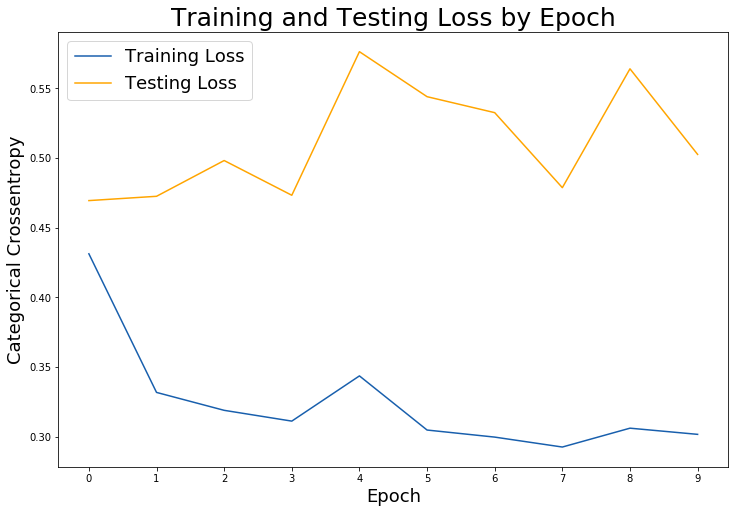

In [21]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);


In [23]:
# Evaluate model on test data.
cnn1_score = model.evaluate(X_train,
                               y_train,
                               verbose=1)

cnn1_labels = model.metrics_names

1463/1463 [==============================] - 2s 1ms/step - loss: 0.3785 - acc: 0.8887


In [24]:
print(f'CNN {cnn1_labels[0]}  : {cnn1_score[0]}')
print(f'CNN {cnn1_labels[1]}   : {cnn1_score[1]}')
print()

CNN loss  : 0.3784801661968231
CNN acc   : 0.8886561989784241



# Subreddit: Anorexia Nervosa

In [25]:
labels = posts['subreddit_AnorexiaNervosa']

#### Train test split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size = .2,
                                                    random_state=42)

In [27]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

#### Defining a model

In [28]:
model2 = Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model2.add(Flatten())
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1600032   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,600,065
Trainable params: 2,600,065
Non-trainable params: 0
_________________________________________________________________


#### Loading the embeddings in the model

The Embedding layer has a single weight matrix: a 2D float matrix where each entry i is the word vector meant to be associated with the index i. 

We will load the Word2Vec matrix we prepared iinto the Embedding layer, the first layer in the model - 

In [29]:
model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False # this freezes the embedding layer as to not 
                                  # be updated during training and forget what they already know

#### Training and evaluating the model

Compile and train the model.

##### Training and evaluation

In [30]:
model2.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['acc'])

history = model2.fit(X_train_sm, 
                    y_train_sm,
                   epochs = 10,
                   batch_size = 32,
                   validation_data = (X_test, y_test))

#model.save_weights('model1.h5')

Epoch 1/10
2602/2602 [==============================] - 11s 4ms/step - loss: 0.5911 - acc: 0.8000 - val_loss: 0.5635 - val_acc: 0.8692
Epoch 2/10
2602/2602 [==============================] - 11s 4ms/step - loss: 0.3420 - acc: 0.8740 - val_loss: 0.5551 - val_acc: 0.8778
Epoch 3/10
2602/2602 [==============================] - 11s 4ms/step - loss: 0.3242 - acc: 0.8758 - val_loss: 0.4901 - val_acc: 0.8808
Epoch 4/10
2602/2602 [==============================] - 11s 4ms/step - loss: 0.3041 - acc: 0.8784 - val_loss: 0.5131 - val_acc: 0.8847
Epoch 5/10
2602/2602 [==============================] - 11s 4ms/step - loss: 0.2987 - acc: 0.8782 - val_loss: 0.5141 - val_acc: 0.8811
Epoch 6/10
2602/2602 [==============================] - 12s 5ms/step - loss: 0.3021 - acc: 0.8801 - val_loss: 0.4700 - val_acc: 0.8855
Epoch 7/10
2602/2602 [==============================] - 11s 4ms/step - loss: 0.2955 - acc: 0.8804 - val_loss: 0.5059 - val_acc: 0.8847
Epoch 8/10
2602/2602 [==============================] -

##### Plotting the results

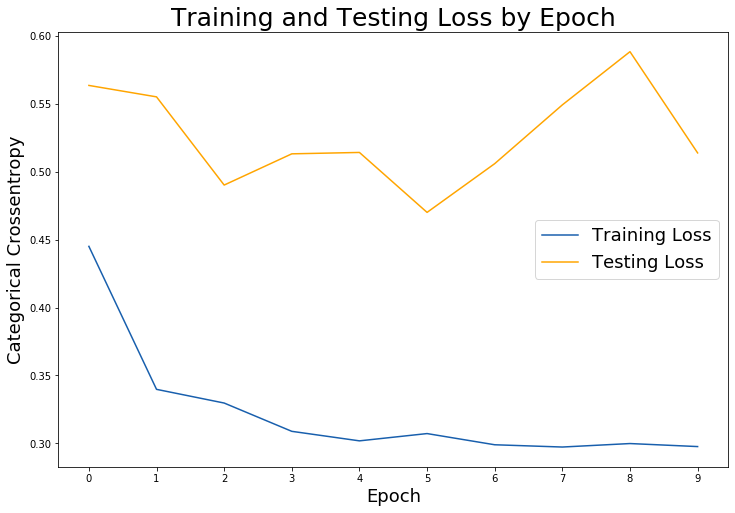

In [31]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);


In [32]:
# Evaluate model on test data.
cnn2_score = model2.evaluate(X_train,
                               y_train,
                               verbose=1)

cnn2_labels = model2.metrics_names

1463/1463 [==============================] - 2s 1ms/step - loss: 0.3713 - acc: 0.8887


In [34]:
print(f'CNN {cnn2_labels[0]}  : {cnn2_score[0]}')
print(f'CNN {cnn2_labels[1]}   : {cnn2_score[1]}')
print()

CNN loss  : 0.37130770087242126
CNN acc   : 0.888741672039032



# Subreddit: BPD

In [36]:
labels = posts['subreddit_BPD']

#### Train test split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size = .2,
                                                    random_state=42)

In [38]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

#### Defining a model

In [39]:
model3 = Sequential()
model3.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model3.add(Flatten())
model3.add(Dense(32, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1600032   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 2,600,065
Trainable params: 2,600,065
Non-trainable params: 0
_________________________________________________________________


#### Loading the embeddings in the model

The Embedding layer has a single weight matrix: a 2D float matrix where each entry i is the word vector meant to be associated with the index i. 

We will load the Word2Vec matrix we prepared iinto the Embedding layer, the first layer in the model - 

In [40]:
model3.layers[0].set_weights([embedding_matrix])
model3.layers[0].trainable = False # this freezes the embedding layer as to not 
                                  # be updated during training and forget what they already know

#### Training and evaluating the model

Compile and train the model.

##### Training and evaluation

In [41]:
model3.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['acc'])

history = model3.fit(X_train_sm, 
                    y_train_sm,
                   epochs = 10,
                   batch_size = 32,
                   validation_data = (X_test, y_test))

#model.save_weights('model1.h5')

Epoch 1/10
2601/2601 [==============================] - 12s 4ms/step - loss: 0.5751 - acc: 0.8014 - val_loss: 0.4467 - val_acc: 0.8757
Epoch 2/10
2601/2601 [==============================] - 11s 4ms/step - loss: 0.3239 - acc: 0.8729 - val_loss: 0.4784 - val_acc: 0.8802
Epoch 3/10
2601/2601 [==============================] - 11s 4ms/step - loss: 0.3043 - acc: 0.8786 - val_loss: 0.5229 - val_acc: 0.8821
Epoch 4/10
2601/2601 [==============================] - 11s 4ms/step - loss: 0.3139 - acc: 0.8748 - val_loss: 0.4663 - val_acc: 0.8867
Epoch 5/10
2601/2601 [==============================] - 11s 4ms/step - loss: 0.3077 - acc: 0.8771 - val_loss: 0.4833 - val_acc: 0.8879
Epoch 6/10
2601/2601 [==============================] - 11s 4ms/step - loss: 0.2974 - acc: 0.8776 - val_loss: 0.5196 - val_acc: 0.8861
Epoch 7/10
2601/2601 [==============================] - 12s 5ms/step - loss: 0.2952 - acc: 0.8798 - val_loss: 0.5485 - val_acc: 0.8851
Epoch 8/10
2601/2601 [==============================] -

##### Plotting the results

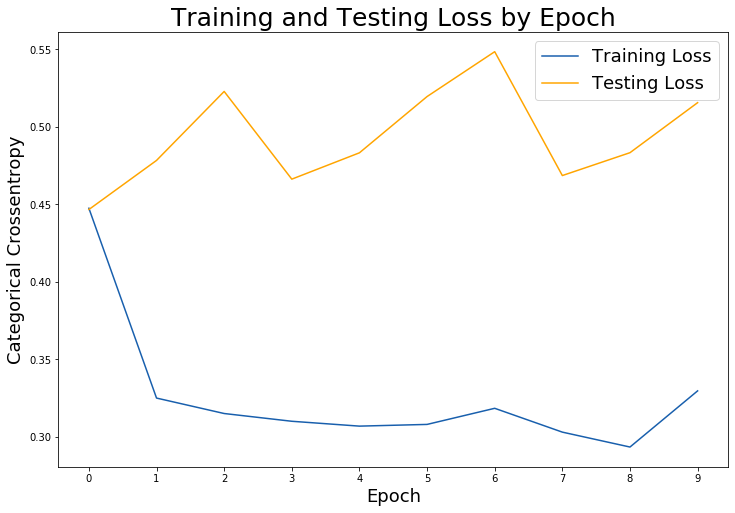

In [42]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);


In [43]:
# Evaluate model on test data.
cnn3_score = model3.evaluate(X_train,
                               y_train,
                               verbose=1)

cnn3_labels = model3.metrics_names

1463/1463 [==============================] - 2s 1ms/step - loss: 0.3740 - acc: 0.8881


In [44]:
print(f'CNN {cnn3_labels[0]}  : {cnn3_score[0]}')
print(f'CNN {cnn3_labels[1]}   : {cnn3_score[1]}')
print()

CNN loss  : 0.37395215034484863
CNN acc   : 0.8880791664123535

